#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><span class="toc-item-num"></font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Импортируем необходимые библиотеки и модули

In [1]:
import pandas as pd
import  matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

Загрузим датафрейм

In [2]:
df = pd.read_csv('taxi.csv')

Посмотрим на первые 10 строк таблицы

In [3]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Таблица состоит из двух столбцов - со временем и количеством заказов. Посмотрим общую информацию о таблице - узнаем встречаются ли в ней пропуски

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Приведём сразу столбец со временем к типу datetime

In [5]:
df['datetime'] =  pd.to_datetime(df['datetime'])

Убедимся, что тип данных изменился - выведем общую информацию о таблице

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Сделаем даты индексами

In [7]:
df = df.set_index(keys='datetime')

Проверим данные на монотонность

In [8]:
df.index.is_monotonic

True

Посмотрим на график временного ряда

<AxesSubplot:xlabel='datetime'>

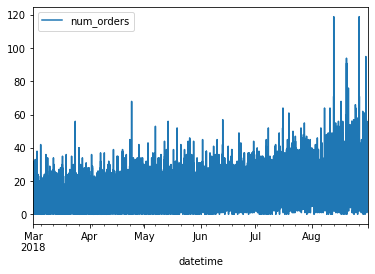

In [9]:
df.plot()

## Ресемплирование

Проведём ресемплирование по сумме значений за каждый час

In [10]:
df = df.resample('1H').sum()

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Данные были предварительно изучены - пропусков обнаружено не было. В качестве индекса были выбраны даты. Мы убедились в монотонности данных. Было проведено ресемплирование по сумме за час. 

## Анализ

Посмотрим на данные на графике

<AxesSubplot:xlabel='datetime'>

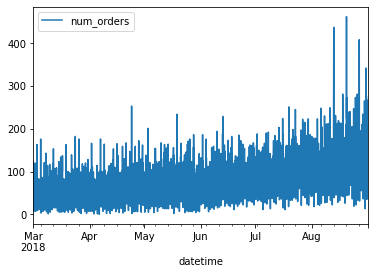

In [11]:
df.plot()

Выведем, данные за какой диапозон нам даны.

In [12]:
print("Начальная дата:", df.index.min())
print("Конечная дата:", df.index.max())

Начальная дата: 2018-03-01 00:00:00
Конечная дата: 2018-08-31 23:00:00


Построим график. Реализуем функцию

In [13]:
def make_plot(df):
    fig, ax = plt.subplots(1)
    ax.set_title('Распределение значений по датам')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    df.plot(figsize=(16,8), ax=ax)

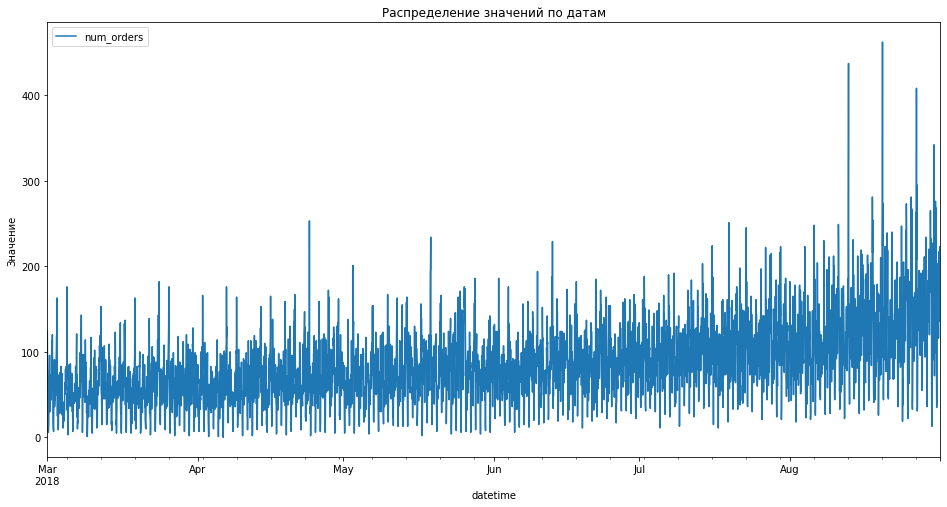

In [14]:
make_plot(df)

Посмотрим на данные за сутки

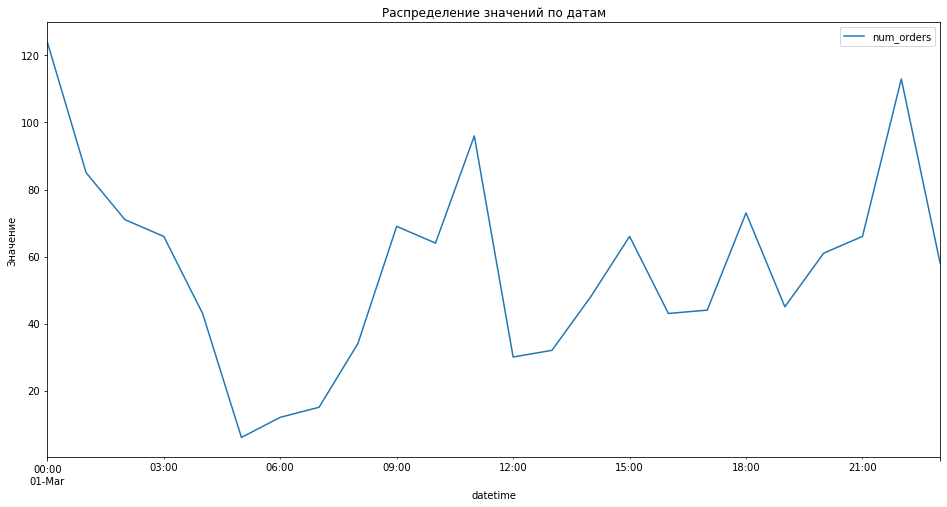

In [15]:
make_plot(df.head(24))

За неделю

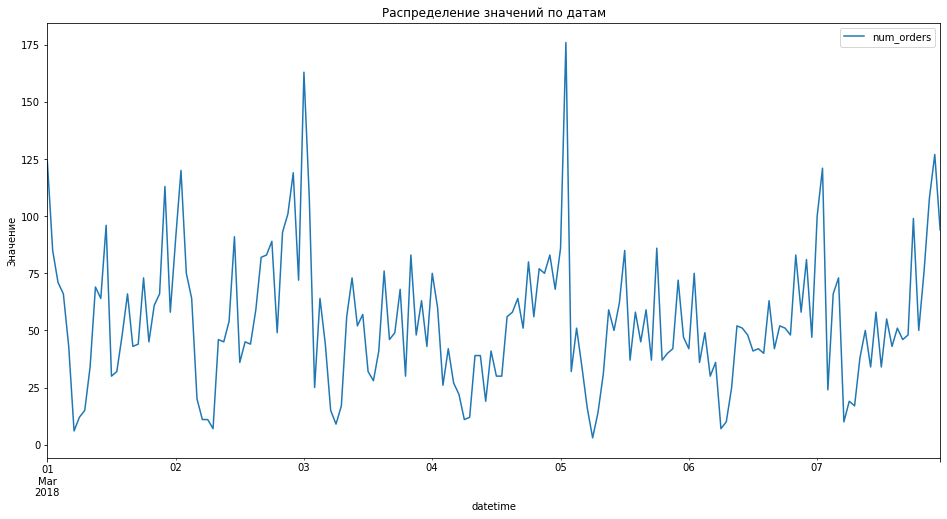

In [16]:
make_plot(df.head(24*7))

Распределение по неделям

In [17]:
df_week = df.resample('1W').mean()

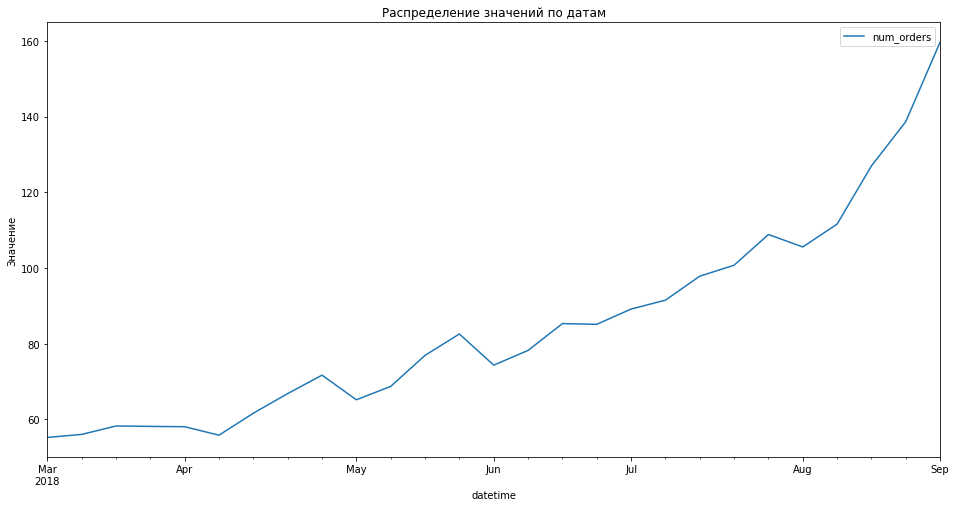

In [18]:
make_plot(df_week)

Разложим временной ряд на тренд, сезонность и остаток

In [19]:
df_decomposed = seasonal_decompose(df)

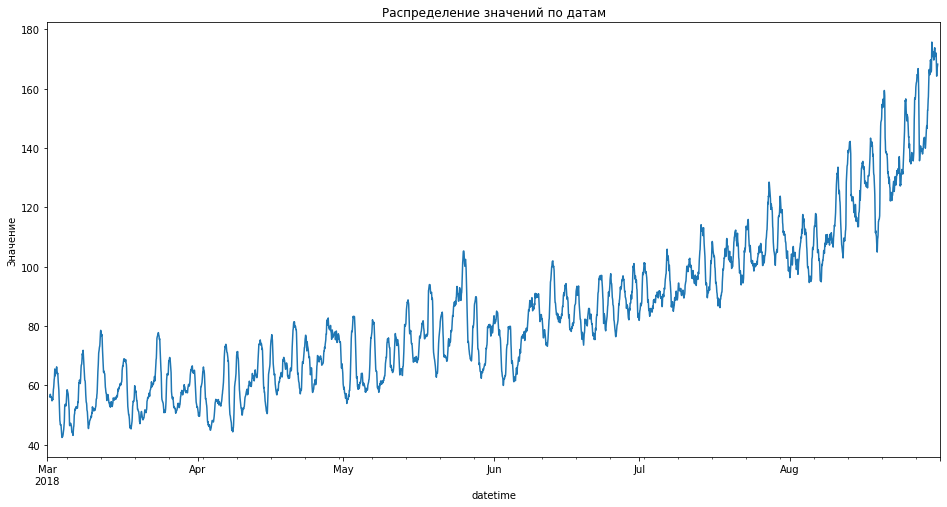

In [20]:
make_plot(df_decomposed.trend)

Сезонность за неделю

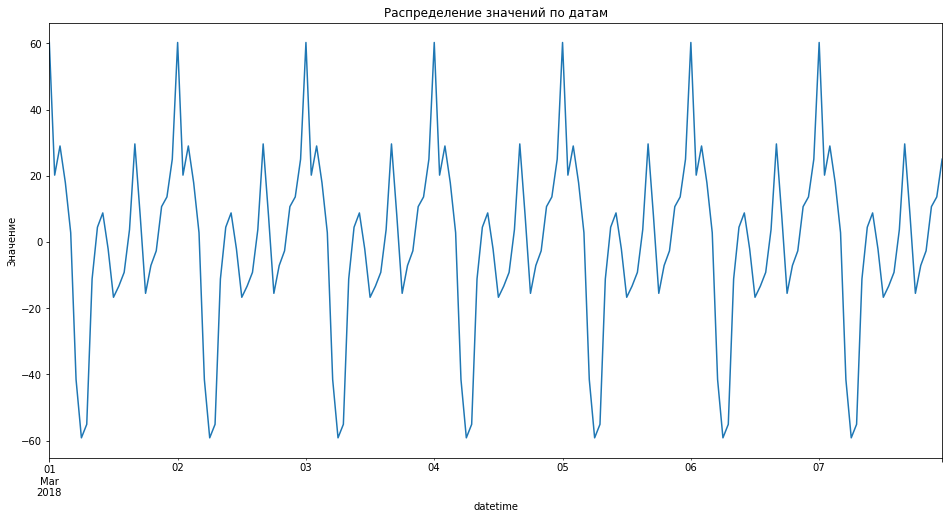

In [21]:
# Сезонность (неделя)
make_plot(df_decomposed.seasonal.head(24*7))

Сезонность за день

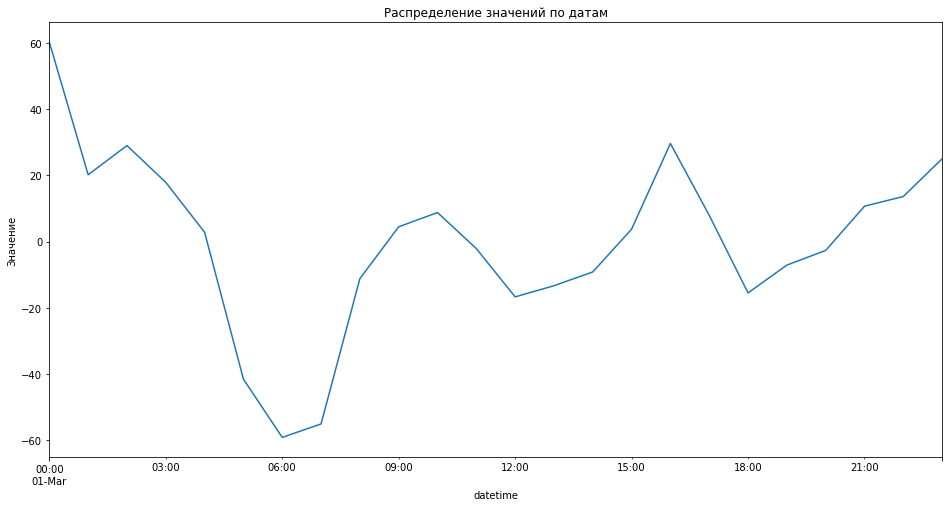

In [22]:
# Сезонность (день)
make_plot(df_decomposed.seasonal.head(24))

Остаток

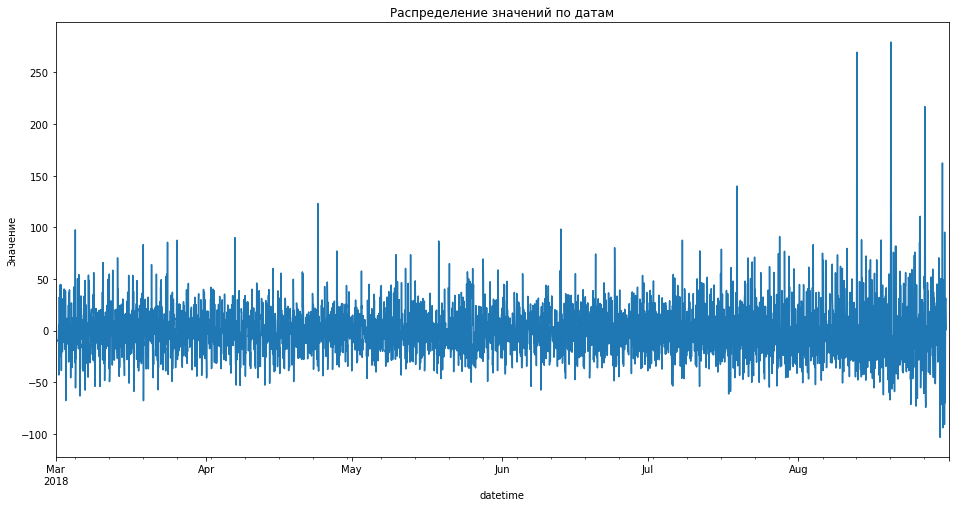

In [23]:
# Остаток
make_plot(df_decomposed.resid)

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

В ходе анализа по графикам можно отметить, что количество заказов с каждым раом растёт, кроме того видна дневная сезонность. 
Если смотреть данные за день, то пики встречаются в полночь и рост ближе к 9 утра и 7 вечера

## Обучение

Добавим в наш датафрейм данные с годом, месяцем, днём, днём недели, отстающие значения и скользящее среднее

In [24]:
def add_features(df, max_lag):
    df_new = df.copy()
    df_new['year'] = df.index.year
    df_new['month'] = df.index.month
    df_new['day'] = df.index.day
    df_new['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df_new['rolling_mean'] = df['num_orders'].shift().rolling(3).mean()
    return df_new

In [25]:
df_new = add_features(df, 24)

In [26]:
df_new

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.000000
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,186.666667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.666667


Поделим данные на выборки - возьмём у функции train_test_split аргумент shuffle=False, поскольку нам не нужно перемешивать данные т.к. мы работаем с временным рядом и не можем предсказывать по будущему прошлое

In [27]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)

Многие модели не умеют работать с пропусками, поэтому создадим отдельные выборки без пропусков

In [28]:
train_without_nan = train.dropna()

Выделим отдельно целевой признак

In [29]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [30]:
features_train_without_nan = train_without_nan.drop(['num_orders'], axis=1)
target_train_without_nan = train_without_nan['num_orders']

Реализуем функцию для подсчёта RMSE

In [31]:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим разные модели

### Случайный лес

In [32]:
tscv = TimeSeriesSplit(n_splits=2)

In [33]:
parameters = {'n_estimators': range(100,201,10),'max_depth': range(1,11,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train_without_nan, target_train_without_nan)

grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 190}

### CatBoostRegressor

Подберём параметр iteration с помощью кросс-валидации

In [34]:
for iteration in range(70, 171, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=6, verbose=10)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=tscv)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.371943
0:	learn: 26.7023421	total: 167ms	remaining: 11.5s
10:	learn: 17.4187149	total: 199ms	remaining: 1.06s
20:	learn: 15.1761958	total: 231ms	remaining: 540ms
30:	learn: 13.1809110	total: 263ms	remaining: 331ms
40:	learn: 11.5232116	total: 294ms	remaining: 208ms
50:	learn: 10.3709144	total: 325ms	remaining: 121ms
60:	learn: 9.2545753	total: 356ms	remaining: 52.6ms
69:	learn: 8.5633178	total: 385ms	remaining: 0us
Learning rate set to 0.414942
0:	learn: 28.2497607	total: 4.87ms	remaining: 336ms
10:	learn: 19.6924609	total: 46ms	remaining: 246ms
20:	learn: 17.5866006	total: 87.8ms	remaining: 205ms
30:	learn: 16.0326098	total: 130ms	remaining: 163ms
40:	learn: 14.6409664	total: 173ms	remaining: 123ms
50:	learn: 13.3517187	total: 218ms	remaining: 81.2ms
60:	learn: 12.2340761	total: 262ms	remaining: 38.7ms
69:	learn: 11.3647627	total: 304ms	remaining: 0us
Score при iterations = 70 : [0.46389758 0.28525858]
Score mean = 0.37457807722052744

Learning rate set to 0.290

Подберём параметр depth

In [35]:
for depth in range(1, 10, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=170, depth=depth, verbose=10)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=tscv)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.180795
0:	learn: 29.1035646	total: 568us	remaining: 96.1ms
10:	learn: 23.8161282	total: 5.27ms	remaining: 76.2ms
20:	learn: 22.0682816	total: 11.4ms	remaining: 80.9ms
30:	learn: 21.2632669	total: 16.3ms	remaining: 73ms
40:	learn: 20.9223996	total: 21.2ms	remaining: 66.6ms
50:	learn: 20.6194029	total: 26.3ms	remaining: 61.3ms
60:	learn: 20.4069472	total: 31ms	remaining: 55.3ms
70:	learn: 20.2735580	total: 38.1ms	remaining: 53.2ms
80:	learn: 20.0833421	total: 43.5ms	remaining: 47.8ms
90:	learn: 19.9337530	total: 48.9ms	remaining: 42.4ms
100:	learn: 19.8074253	total: 54.6ms	remaining: 37.3ms
110:	learn: 19.6956069	total: 59.4ms	remaining: 31.6ms
120:	learn: 19.5839008	total: 65.4ms	remaining: 26.5ms
130:	learn: 19.4801631	total: 70.3ms	remaining: 20.9ms
140:	learn: 19.3918121	total: 76.2ms	remaining: 15.7ms
150:	learn: 19.3044540	total: 83.1ms	remaining: 10.4ms
160:	learn: 19.2201401	total: 88.3ms	remaining: 4.94ms
169:	learn: 19.1473069	total: 92.6ms	remaining: 0us

Для CatBoost оптимальными праметрами оказались iterations=170, depth=5

### LGBMRegressor

In [36]:
params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 7, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [37]:
lgbm_model = LGBMRegressor(**params1)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMRegressor(max_depth=7, metric='rmse', objective='regression', verbose=0)

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

В данные были добавлены новые фичи. Данные были разделены на выборки
Были рассмотрены и обучены три модели - случайный лес, CatBoost и LGBM. Для первых двух были подобраны параметры.

## Тестирование

### Случайный лес

In [38]:
model_forest = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=190, random_state=42)
model_forest.fit(features_train_without_nan, target_train_without_nan)
predictions_rf = model_forest.predict(features_test)

In [39]:
rmse(target_test, predictions_rf)

44.083603646602626

### CatBoost

In [40]:
cat_model= CatBoostRegressor(loss_function="RMSE", iterations=170, depth=5, verbose=10)
cat_model.fit(features_train, target_train)
predicted_cat = pd.Series(cat_model.predict(features_test))

Learning rate set to 0.215032
0:	learn: 35.0599147	total: 3.65ms	remaining: 617ms
10:	learn: 25.1322539	total: 33ms	remaining: 477ms
20:	learn: 23.7426776	total: 62.3ms	remaining: 442ms
30:	learn: 22.7386851	total: 93.5ms	remaining: 419ms
40:	learn: 22.0412864	total: 129ms	remaining: 407ms
50:	learn: 21.3255859	total: 163ms	remaining: 381ms
60:	learn: 20.6495251	total: 198ms	remaining: 353ms
70:	learn: 19.9152471	total: 230ms	remaining: 321ms
80:	learn: 19.3325515	total: 262ms	remaining: 288ms
90:	learn: 18.6788490	total: 295ms	remaining: 256ms
100:	learn: 18.1953760	total: 328ms	remaining: 224ms
110:	learn: 17.7762662	total: 360ms	remaining: 192ms
120:	learn: 17.3145196	total: 394ms	remaining: 160ms
130:	learn: 16.8751177	total: 430ms	remaining: 128ms
140:	learn: 16.4434128	total: 463ms	remaining: 95.3ms
150:	learn: 16.0865878	total: 498ms	remaining: 62.6ms
160:	learn: 15.7686762	total: 532ms	remaining: 29.8ms
169:	learn: 15.4939657	total: 563ms	remaining: 0us


In [41]:
rmse(target_test, predicted_cat)

42.44108787312567

### LGBM

In [42]:
predictions_lgbm = lgbm_model.predict(features_test)

In [43]:
rmse(target_test, predictions_lgbm)

40.90347430732211

Видим, что LGBM показывает наилучший результат

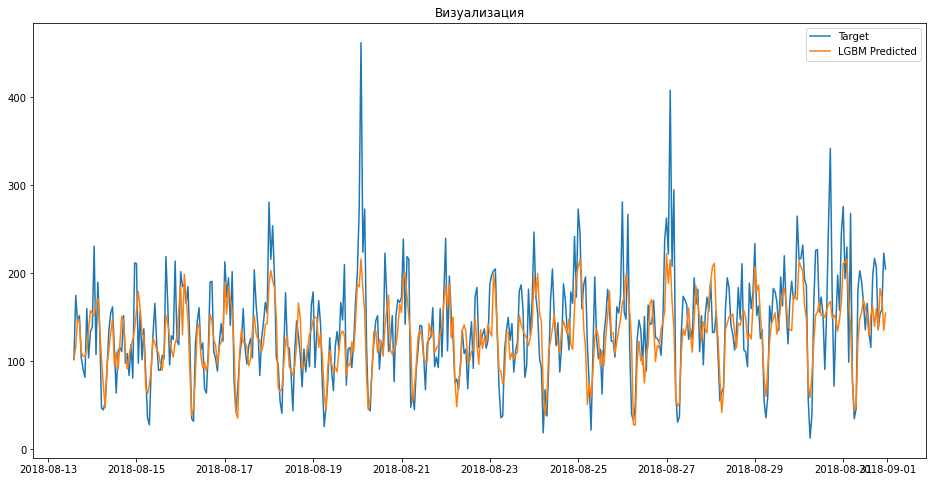

In [44]:
plt.figure(figsize=(16, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predictions_lgbm, label='LGBM Predicted')
plt.title('Визуализация')
plt.legend()
plt.show()

## Выводы

* Итак, данные были изучены и предобработаны
* Было рассмотрено 3 модели, которые были обучены
* Была отобрана лучшая модель - LGBM, RMSE которой получился 6.878